# Once Upon a Time: Interactive Learning for Storytelling with Small Language Models
Supplementary Code by Jonas Mayer Martins

Visualization script

August 2025

## Helper functions

In [2]:
# Plotting util functions
import PyPDF2
import os
import matplotlib.pyplot as plt
os.environ['MallocStackLogging'] = '0'

def init_latex(fontsize):
    # LaTeX fonts, paper figure sizing utilities
    os.environ['PATH'] += os.pathsep + '/Library/TeX/texbin'
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "axes.labelsize": fontsize,
        "font.size": fontsize,
        "legend.fontsize": fontsize,
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
        "lines.solid_capstyle": "round"
    })

def set_size(width_pt=451, ncols=2, fraction=1, aspect_ratio=None):
    # ncols:
    # 1: one-column wide figure in two-column environment
    # 2: two-column wide figure in two-column environment
    if ncols == 1:
        width_pt = 217 # pts
    elif ncols == 2:
        width_pt = 451 # pts
    else:
        print(f"Using default widht of {width_pt} pts.")
    fig_width_pt = width_pt * fraction
    #cm_per_pt = 0.03528
    in_per_pt = 0.013889
    if aspect_ratio is None:
        aspect_ratio = (5**.5 - 1) / 2  # Golden ratio
    fig_width_in = fig_width_pt * in_per_pt
    fig_height_in = fig_width_in * aspect_ratio
    return (fig_width_in, fig_height_in)

def check_pdf_size(filename, figsize, fraction):
    """
    Saving with bbox_inches='tight', e.g.,
    plt.savefig("figs/BLM_eval_fast.pdf", bbox_inches='tight', pad_inches=0)
    yields a smaller figsize than expected when setting figsize at the top. Thus compare and set fraction with set_size.
    """
    # Open PDF and get its MediaBox size (in points)
    with open(filename, 'rb') as f:
        reader = PyPDF2.PdfReader(f)
        page = reader.pages[0]
        width_pts = float(page.mediabox.width)
        height_pts = float(page.mediabox.height)
    in_per_pt = 1 / 72.0
    width_in  = width_pts * in_per_pt
    height_in = height_pts * in_per_pt

    print(f"=== PDF actual area ===:")
    print(f"  {width_pts:.2f}pt x {height_pts:.2f}pt  ||  {width_in:.4f}in x {height_in:.4f}in")

    print(f"=== Your target figsize from set_size, corrected for fraction:")
    print(f"  {figsize[0]*72/fraction:.2f}pt x {figsize[1]*72/fraction:.2f}pt  ||  {figsize[0]/fraction:.4f}in x {figsize[1]/fraction:.4f}in")

    print(f"=== Ratio (actual/target):")
    print(f"  width: {width_pts/(figsize[0]*72/fraction):.2%},  height: {height_pts/(figsize[1]*72/fraction):.2%}")
    return width_in, height_in, width_pts, height_pts


fontsize = 11
init_latex(fontsize)

## PPO Training

In [1]:
import os
import re
import yaml
import pandas as pd
from pathlib import Path

# Constants (adapt as needed)
DATA_ROOT = "data_ppo_training"
META_DATA_DIR = "meta_data"
BATCH_STATS_FILE = "batch_stats.csv"
GENERATED_FILE = "generated.csv"
CONFIG_FILE = "ppo.yaml"
CHECKPOINT_PATTERN = r"chck_(\d+)M"
SEED_PATTERN = r"seed(\d+)"

def find_checkpoints(data_root):
    """Finds all subfolders matching 'chck_...M' pattern and returns their paths and revision numbers."""
    results = []
    for entry in Path(data_root).iterdir():
        if entry.is_dir():
            match_rev = re.search(CHECKPOINT_PATTERN, entry.name)
            match_seed = re.search(SEED_PATTERN, entry.name)
            if match_rev:
                revision = match_rev.group(1)  # e.g., 90
                seed = int(match_seed.group(1)) if match_seed else None
                results.append((entry, revision, seed))
    return results

def extract_scores(text):
    score_regex = re.compile(r"\b(\d)\b[ ,]+(\d)\b[ ,]+(\d)\b")
    m = score_regex.search(str(text))
    if m:
        s1, s2, s3 = (int(x) for x in m.groups())
        return pd.Series([s1, s2, s3, s1 + s2 + s3, (s1 + s2 + s3) / 9],
                         index=['Readability', 'Coherence', 'Creativity', 'score_sum', 'teacher_reward_from_generate'])
    else:
        return pd.Series([None] * 5, index=['Readability', 'Coherence', 'Creativity', 'score_sum', 'teacher_reward_from_generate'])

def process_generated_csv(path_to_csv):
    df = pd.read_csv(path_to_csv)
    score_fields = df['teacher_output'].apply(extract_scores)
    df = pd.concat([df, score_fields], axis=1)
    df['story_length'] = df['student_output'].astype(str).str.split().apply(len)
    return df

def process_batch_stats_csv(path_to_csv):
    return pd.read_csv(path_to_csv)

def load_config_yaml(path_to_yaml):
    with open(path_to_yaml, "r") as f:
        return yaml.safe_load(f)

def batch_score_aggregation(df_generated, batch_size):
    """
    For each batch (N stories), computes the mean and std of the scores,
    and also the per-batch fractions for every score value (e.g., Readability_count_0, etc).
    Prepends 'avg_' and 'std_' to column names.
    Returns a DataFrame with all these stats concatenated.
    """
    score_cols = ['Readability', 'Coherence', 'Creativity', 'score_sum', 'teacher_reward_from_generate']
    main_score_cols = ['Readability', 'Coherence', 'Creativity']
    possible_values = [0, 1, 2, 3]  # adjust as appropriate

    df_nonan = df_generated.dropna(subset=score_cols).reset_index(drop=True)
    batches = (df_nonan.index // batch_size)
    grouped = df_nonan.groupby(batches)

    # Means & stds
    batch_means = grouped[score_cols].mean().reset_index(drop=True)
    batch_stds  = grouped[score_cols].std().reset_index(drop=True)
    batch_means = batch_means.rename(columns={col: f"avg_{col}" for col in score_cols})
    batch_stds  = batch_stds.rename(columns={col: f"std_{col}" for col in score_cols})

    # Fractions (proportions) of each possible value for each score column
    fractions = {}
    for score in main_score_cols:
        for value in possible_values:
            # For each batch, compute fraction of entries equal to `value`
            name = f"{score}_count_{value}"
            # Here, value_counts() alone is not enough; use apply
            props = grouped[score].apply(lambda x: (x == value).sum() / len(x) if len(x) > 0 else 0)
            fractions[name] = props.values

    fractions_df = pd.DataFrame(fractions)

    # Concatenate all together: means, stds, and value fractions
    batch_scores = pd.concat([batch_means, batch_stds, fractions_df], axis=1)
    return batch_scores

def get_revision(df, revision):
    """
    Returns the dataframe for a given revision number (90, 200, 500)
    """
    return df[df["revision_number"] == str(revision)]

checkpoints = find_checkpoints(DATA_ROOT)
print(f"Found {len(checkpoints)} checkpoints.")

batch_stats_dict_all_seeds = {}
generated_dict_all_seeds = {}

batch_stats_dict = {}
generated_dict = {}

for checkpoint_path, revision_number, rl_seed in checkpoints:
    meta_data_path = checkpoint_path / META_DATA_DIR
    gen_file = meta_data_path / GENERATED_FILE
    batch_file = meta_data_path / BATCH_STATS_FILE
    config_file = meta_data_path / CONFIG_FILE

    if not (gen_file.exists() and batch_file.exists() and config_file.exists()):
        print(f"Skipping {checkpoint_path.name}: missing files.")
        continue

    # Load per-checkpoint config for batch size
    config = load_config_yaml(config_file)
    batch_size = config.get("batch_size", None)
    if batch_size is None:
        print(f"Config for {checkpoint_path.name} missing 'batch_size'. Skipping.")
        continue

    df_generated = process_generated_csv(gen_file)
    df_batch = process_batch_stats_csv(batch_file)

    # Remove specified field, rename columns
    if 'new_old_ratio' in df_batch.columns:
        df_batch = df_batch.drop(columns=['new_old_ratio'])
    batch_rename_map = {
        'mean_total_reward': 'avg_total_reward',
        'mean_non_reward': 'avg_non_reward'
    }
    df_batch = df_batch.rename(columns=batch_rename_map)

    df_batch['interaction_round'] = list(df_batch.index * batch_size) # add interaction_round as variable

    # Batch-aggregate readability etc. scores
    batch_scores = batch_score_aggregation(df_generated, batch_size)

    # Merge them side by side (ensure same length/order)
    df_combined = pd.concat(
        [df_batch.reset_index(drop=True), batch_scores.reset_index(drop=True)], axis=1
    )

    # Store in all-seed dicts
    batch_stats_dict_all_seeds[(revision_number, rl_seed)] = df_combined
    generated_dict_all_seeds[(revision_number, rl_seed)] = df_generated

    # Store only seed==42 in legacy dicts
    if rl_seed == 42:
        batch_stats_dict[revision_number] = df_combined
        generated_dict[revision_number] = df_generated


    print(f"Processed {checkpoint_path.name}: {len(df_generated)} stories, {len(batch_scores)} batches.")

# Collate all seeds into DataFrames
df_batch_all_seeds = pd.concat(
    [df.assign(revision_number=rev, RL_seed=seed)
     for (rev, seed), df in batch_stats_dict_all_seeds.items()],
    ignore_index=True
)
df_generated_all_seeds = pd.concat(
    [df.assign(revision_number=rev, RL_seed=seed)
     for (rev, seed), df in generated_dict_all_seeds.items()],
    ignore_index=True
)

# Legacy variables: only seed 42
df_batch = pd.concat(
    [df.assign(revision_number=rev, RL_seed=42)  # all are RL_seed=42
     for rev, df in batch_stats_dict.items()],
    ignore_index=True
)
df_generated = pd.concat(
    [df.assign(revision_number=rev, RL_seed=42)
     for rev, df in generated_dict.items()],
    ignore_index=True
)

length_coeff = 0.4
df_generated_all_seeds['teacher_and_length_reward'] = (
    df_generated_all_seeds['score_sum'] / 9 +
    length_coeff * df_generated_all_seeds['story_length'] / 100
) / (1 + length_coeff)

df_generated['teacher_and_length_reward'] = (
    df_generated['score_sum'] / 9 +
    length_coeff * df_generated['story_length'] / 100
) / (1 + length_coeff)


print("\nSample batch stats (seed 42 only):")
print(df_batch.head())


Found 8 checkpoints.
Processed blm-gpt2s-90M-s42_chck_900M_ppo-1000K-seed42__2025-08-14__11-01-33: 331200 stories, 920 batches.
Processed blm-gpt2s-90M-s42_chck_90M_ppo-1000K-seed42__2025-08-14__13-54-57: 331200 stories, 920 batches.
Processed blm-gpt2s-90M-s42_chck_50M_ppo-1000K-seed42__2025-08-14__11-49-23: 331200 stories, 920 batches.
Processed blm-gpt2s-90M-s42_chck_200M_ppo-1000K-seed42__2025-08-14__17-19-05: 331200 stories, 920 batches.
Processed blm-gpt2s-90M-s42_chck_20M_ppo-1000K-seed42__2025-08-14__12-11-06: 331200 stories, 920 batches.
Processed blm-gpt2s-90M-s42_chck_900M_ppo-1000K-seed44__2025-08-14__19-01-45: 331200 stories, 920 batches.
Processed blm-gpt2s-90M-s42_chck_900M_ppo-1000K-seed43__2025-08-14__18-38-26: 331200 stories, 920 batches.
Processed blm-gpt2s-90M-s42_chck_500M_ppo-1000K-seed42__2025-08-14__14-56-07: 331200 stories, 920 batches.

Sample batch stats (seed 42 only):
   avg_teacher_reward  std_teacher_reward  avg_length_bonus  std_length_bonus  \
0        

#### Look at example stories

In [3]:
# Sort by total score (descending) and take the top 5
# Sort by total score_sum (descending), then by teacher_and_length_reward (descending)
top_stories = df_generated.sort_values(
    ['teacher_and_length_reward','score_sum', ],
    ascending=[False, False]
).head(5)

for idx, row in top_stories.iterrows():
    print(f"Score: {row['score_sum']} | Reward: {row['teacher_and_length_reward']:.2f} | Story Length: {row['story_length']} | Interaction: {idx} |Model: {row['revision_number']} M")
    print(row['student_output'])
    print('-' * 80)

top_stories[['student_output', 'score_sum', 'Readability', 'Coherence', 'Creativity', 'story_length']]

Score: 8.0 | Reward: 0.85 | Story Length: 76 | Interaction: 8820 |Model: 900 M
 everything seemed as if it were a fairy tale—so much as you have told us a great story that we cannot bear to believe. There was something, however, very different from the description of the whole story, most surprising. If the story reached out, then, and it was always the story at the end, it was always something inexpressibly a story that made a great deal of sense. But it was all a mistake and wonder
--------------------------------------------------------------------------------
Score: 8.0 | Reward: 0.85 | Story Length: 76 | Interaction: 255512 |Model: 900 M
 a man of small experience had disposed of the delights and magnitude of the soul, and could have been recollected elsewhere, somehow or other. Even when the flame over his forehead fell, he had felt hardly any change in his eyes. He had never seen so beautiful a human being before. And every person must be looking at him, in spite of him or her o

,student_output,score_sum,Readability,Coherence,Creativity,story_length
8820,everything seemed as if it were a fairy tale—...,8.0,2.0,3.0,3.0,76
255512,a man of small experience had disposed of the...,8.0,2.0,3.0,3.0,76
245523,"I told the traveller to try some hard thing, ...",8.0,2.0,3.0,3.0,74
241088,"a man, who pushed his sick vulture from some ...",8.0,2.0,3.0,3.0,72
279225,"in a lower almost hole, there was little hope...",8.0,2.0,3.0,3.0,71


In [4]:
import numpy as np

# Set random seed and model size
seed = 42
selected_model_size = 900  # change as needed

np.random.seed(seed)

# Filter and reindex the DataFrame for the selected model
df_model = df_generated[df_generated['revision_number'] == str(selected_model_size)].reset_index(drop=True)
df_model.index = df_model.index + 1  # make index start at 1

n = len(df_model)
if n == 0:
    print(f"No stories found for model size {selected_model_size}M.")
else:
    # Calculate split indices
    first_third_end = n // 3
    second_third_end = 2 * n // 3

    # Split into thirds
    first_third = df_model.iloc[:first_third_end]
    second_third = df_model.iloc[first_third_end:second_third_end]
    last_third = df_model.iloc[second_third_end:]

    def random_story(df_section):
        return df_section.sample(n=1).iloc[0]

    def best_story(df_section):
        return df_section.sort_values(
            ['teacher_and_length_reward', 'score_sum'],
            ascending=[False, False]
        ).head(1).iloc[0]

    # Select required stories
    rand_first = random_story(first_third)
    rand_second = random_story(second_third)
    rand_last = random_story(last_third)
    overall_best = best_story(df_model)

    # Prepare output
    selections = [
        ('First third (random)', rand_first),
        ('Second third (random)', rand_second),
        ('Last third (random)', rand_last),
        ('Overall best', overall_best)
    ]

    for label, story in selections:
        print(f"{label} (Interaction: {story.name}):")
        print(f"Score: {story['score_sum']} | Reward: {story['teacher_and_length_reward']:.2f} | Story Length: {story['story_length']} | Readability {int(story['Readability'])} | Coherence {int(story['Coherence'])} | Creativity {int(story['Creativity'])} | Model: {story['revision_number']} M")
        print(story['student_output'])
        print('-' * 80)

First third (random) (Interaction: 43434):
Score: 5.0 | Reward: 0.61 | Story Length: 76 | Readability 1 | Coherence 2 | Creativity 2 | Model: 900 M
 there lived old men like me, the flowers of Jed serene rose from every mountain and valley, and they grew wildly from one to another. The inhabitants of those under one tree and the branches in the other, had been bewitched in their own world by their native dwelling; but having enabled them to approach them they had for good to take an active place among mankind. They resided many weary people, but had always a
--------------------------------------------------------------------------------
Second third (random) (Interaction: 217857):
Score: 1.0 | Reward: 0.26 | Story Length: 63 | Readability 1 | Coherence 0 | Creativity 0 | Model: 900 M
 there lived an unquenchable king. But cannot the words wear off, and for ten days he was forced to stake his head on one native bird-cage, while the hunters came in for us the fish-skin preservation. He 

#### Define colors for plotting

In [5]:
# Define PPO model colors
import matplotlib.pyplot as plt
cmap = plt.get_cmap('plasma_r')
revision_numbers = sorted(batch_stats_dict.keys(), key=lambda r: int(str(r).replace('M', '')))
N = len(revision_numbers)
# colors = [cmap(i) for i in range(N)] #  for discrete colormaps
ppo_colors = [cmap( (i + 1.5) / (N - 1 + 2)) for i in range(N)] # for continuous colormaps

# color: array-like (r, g, b), each in [0, 1]
def blend_with_white(color, amount=0.5):
    # amount: 0 = original color, 1 = pure white
    color = np.array(color[:3])
    return tuple((1 - amount) * color + amount * 1.0)


## Teacher score by category

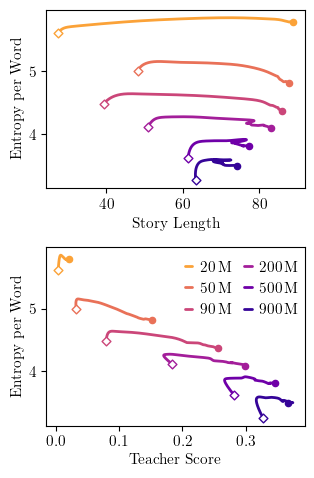

In [7]:
plt.show()
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

sigma = 30
cmap = plt.get_cmap('tab10')
revision_numbers = sorted(
    batch_stats_dict.keys(),
    key=lambda x: int(str(x).replace('M', ''))
)
colors = [cmap(i) for i in range(len(revision_numbers))]

fraction=1.0/0.92
figsize = set_size(ncols=1,fraction=fraction, aspect_ratio=1.5)
fig, axes = plt.subplots(2, 1, figsize=figsize)

for color, revision in zip(ppo_colors, revision_numbers):
    df = batch_stats_dict[revision]
    student_len = df['student_len'].to_numpy()
    entropy_per_word = (df['entropy'] / df['student_len']).to_numpy()
    score = df['avg_teacher_reward'].to_numpy()

    # Smooth all axes
    student_len_smooth = gaussian_filter1d(student_len, sigma=sigma, mode='nearest')
    entropy_per_word_smooth = gaussian_filter1d(entropy_per_word, sigma=sigma, mode='nearest')
    score_smooth = gaussian_filter1d(score, sigma=sigma, mode='nearest')

    # Panel 1: Story Length vs Entropy per Word
    axes[0].plot(student_len_smooth, entropy_per_word_smooth, linewidth=2, color=color, label=rf"{revision}\,M")
    # Start marker ("x")
    axes[0].scatter(student_len_smooth[0], entropy_per_word_smooth[0], marker='D', facecolor='white', color=color, s=20, zorder=5)
    # End marker ("o")
    axes[0].scatter(student_len_smooth[-1], entropy_per_word_smooth[-1], marker='o', color=color, s=20, zorder=5)

    # Panel 2: Entropy per Word vs Teacher Score
    axes[1].plot(score_smooth, entropy_per_word_smooth, linewidth=2, color=color, label=rf"{revision}\,M")
    # Start marker ("x")
    axes[1].scatter(score_smooth[0], entropy_per_word_smooth[0], marker='D', facecolor='white', color=color, s=20, zorder=5)
    # End marker ("o")
    axes[1].scatter(score_smooth[-1], entropy_per_word_smooth[-1], marker='o', color=color, s=20, zorder=5)

# Labels and layout
axes[0].set_xlabel('Story Length')
axes[0].set_ylabel('Entropy per Word')
axes[1].set_xlabel('Teacher Score')
axes[1].set_ylabel('Entropy per Word')

axes[1].legend(frameon=False, loc='upper right', handlelength=0.5, handletextpad=0.5, ncols=2, columnspacing=0.8, bbox_to_anchor=[1.03,1])
plt.tight_layout()
#plt.savefig("figs/PPO_entropy_v_reward.pdf", bbox_inches='tight', pad_inches=0.02)
#check_pdf_size("figs/PPO_entropy_v_reward.pdf", figsize, fraction)
plt.show()

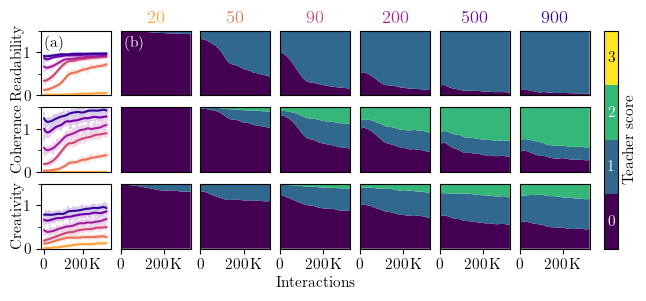

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
from scipy.ndimage import gaussian_filter1d
import matplotlib.colors as mcolors
import re

score_list = ['Readability', 'Coherence', 'Creativity']
possible_values = [0, 1, 2, 3]
cmap = plt.get_cmap('viridis')
score_colors = [cmap(i / 3) for i in range(4)]

def revision_key(revision):
    m = re.match(r"(\d+)", str(revision))
    return int(m[1]) if m else float('inf')

revision_numbers = sorted(batch_stats_dict.keys(), key=revision_key)
n_models = len(revision_numbers)
n_scores = len(score_list)

fraction = 1.0 /  0.8847
main_grid_cols = n_models
total_cols = main_grid_cols + 1  # +1 for the left stacked score panels

figsize = set_size(ncols=2, fraction=fraction, aspect_ratio=0.4)
fig = plt.figure(figsize=figsize)

# Gridspec: left column for scores, right for main grid
gs = GridSpec(n_scores, total_cols, width_ratios=[1] + [1]* main_grid_cols, wspace=0.14, hspace=0.18, figure=fig)

# Score axes (left column)
score_axes = [fig.add_subplot(gs[i, 0]) for i in range(n_scores)]
# Main grid panels
main_axes = np.array([[fig.add_subplot(gs[i, j+1]) for j in range(main_grid_cols)] for i in range(n_scores)])

sigma = 30
skip = 20
skip_unsmoothed = 1
lw = 1.5

# ----- stacked panels (left column) -----
for i, score in enumerate(score_list):
    ax = score_axes[i]
    for color, revision in zip(ppo_colors, revision_numbers):
        df = batch_stats_dict[revision]
        interaction_round = df['interaction_round'].values / 1e5
        y = df[f'avg_{score}'].values
        y_smooth = gaussian_filter1d(y, sigma=sigma, mode='nearest')
        pale = blend_with_white(mcolors.to_rgb(color), amount=0.8)
        ax.plot(interaction_round[::skip_unsmoothed], y[::skip_unsmoothed], alpha=1, color=pale, linewidth=1)
        ax.plot(interaction_round[::skip], y_smooth[::skip], color=color, linewidth=lw, label=rf"{revision}\,M", zorder=3)
    if i == 2:
        ax.set_xticks([0, 2])
        ax.set_xticklabels([0,r'200\,K'])
    else:
        ax.set_xticks([])
    ax.set_ylim(0, 1.23)
    ax.set_ylabel(score, labelpad=0)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['0', '1'])
    ax.set_yticks([0.5, 1.5], minor=True)
    #if i == len(score_list) - 1:
    #    ax.set_xlabel(r'Round ($\times 10^5$)')
#score_axes[0].legend(
#    frameon=False, handlelength=0.7, handletextpad=0.4, ncols=2,
#    loc='upper left', bbox_to_anchor=(0.0, 1.03)
#)

# ----- main grid (right of left column) -----
for j, revision in enumerate(revision_numbers):
    df = batch_stats_dict[revision]
    interaction_round = df['interaction_round'].values / 1e5
    for i, score in enumerate(score_list):
        ax = main_axes[i, j]
        fraction_cols = [f"{score}_count_{v}" for v in possible_values]
        score_fractions = df[fraction_cols].values.T
        smoothed_counts = np.array([
            gaussian_filter1d(row, sigma=sigma, mode='nearest')
            for row in score_fractions
        ])
        ax.stackplot(interaction_round[::skip], smoothed_counts[:, ::skip], colors=score_colors, alpha=1)
        ax.set_xlim(interaction_round.min(), interaction_round.max() - skip * batch_size / 1e5)
        ax.set_ylim(0, 1)
        if i == 0:
            ax.set_title(f"{revision}", color=ppo_colors[j])

for i in range(n_scores):
    for j in range(n_models):
        ax = main_axes[i, j]
        if i != 2:
            ax.set_xticks([])
        else:
            ax.set_xticks([0, 2])
            ax.set_xticklabels([0,r'200\,K'])
        ax.set_yticks([])
        if i == n_scores - 1 and j == 2:
            ax.set_xlabel(r"Interactions")
            #ax.xaxis.set_label_coords(-0.06, -0.35)

# ----- Colorbar to the right -----
cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77])
boundaries = np.arange(-0.5, 4.5, 1)
sm = plt.cm.ScalarMappable(cmap=ListedColormap(score_colors), norm=plt.Normalize(vmin=0, vmax=3))
cbar = fig.colorbar(
    sm,
    cax=cbar_ax,
    boundaries=boundaries,
    ticks=possible_values,
    orientation='vertical',
)
cbar.set_label("Teacher score")
cbar.set_ticklabels([str(v) for v in possible_values])
cbar.set_ticks([])

# Annotate bins in colorbar
cbar_axis = cbar.ax
cbar_pos = cbar_axis.get_position()
ymin, ymax = cbar_axis.get_ylim()
bin_height = (ymax - ymin) / len(possible_values)
for i, val in enumerate(possible_values):
    y = ymin + (i + 0.5) * bin_height
    cbar_axis.text(
        0.55, y, str(val),
        ha='center', va='center',
        fontsize=fontsize, color = 'white' if i < 3 else 'black',
        transform=cbar_axis.transData
    )

# (a): to the left of the top score panel (Y-centered, X just outside axes)
score_axes[0].text(
    0.06, 0.92, "(a)", fontsize=fontsize, fontweight="bold",
    ha="left", va="top", transform=score_axes[0].transAxes
)

# (b): to the left of the top left main plot
main_axes[0,0].text(
    0.06, 0.92, "(b)", fontsize=fontsize, fontweight="bold",
    ha="left", va="top", transform=main_axes[0,0].transAxes, color='white'
)

#plt.savefig("figs/PPO_category.pdf", bbox_inches='tight', pad_inches=0.02)
#check_pdf_size("figs/PPO_category.pdf", figsize, fraction)
plt.show()

Rather show only mean (and story length?) for all models combined

Mention size of standard deviation per batch.

Bend happens due to KL divergence kicking in

## PPO before / after

Start/end values (mean ± std over 10 batches)


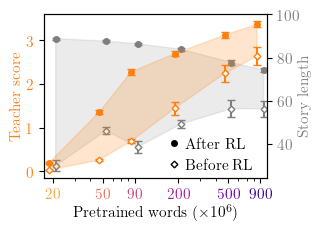

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as mcolors

def average_edge(arr, n=10):
    arr = np.asarray(arr)
    if len(arr) < n:
        return (arr.mean(), arr.std()), (arr.mean(), arr.std())
    return (
        (arr[:n].mean(), arr[:n].std()),
        (arr[-n:].mean(), arr[-n:].std())
    )

revision_numbers = sorted(
    batch_stats_dict.keys(),
    key=lambda x: int(str(x).replace('M',''))
)
x_vals = np.array([float(str(r).replace('M','')) for r in revision_numbers])
offset = 0.12 * x_vals

# Collect means and stds for start/end (teacher, len)
n_avg = 10  # number of batches for averaging
markersize = 4

score_start_means, score_end_means, score_start_stds, score_end_stds = [], [], [], []
len_start_means, len_end_means, len_start_stds, len_end_stds = [], [], [], []

for rev in revision_numbers:
    df = batch_stats_dict[rev]
    scores = df['avg_score_sum'].values
    lens = df['student_len'].values
    (score_start_mean, score_start_std), (score_end_mean, score_end_std) = average_edge(scores, n=n_avg)
    (len_start_mean, len_start_std), (len_end_mean, len_end_std) = average_edge(lens, n=n_avg)
    score_start_means.append(score_start_mean)
    score_end_means.append(score_end_mean)
    score_start_stds.append(score_start_std)
    score_end_stds.append(score_end_std)
    len_start_means.append(len_start_mean)
    len_end_means.append(len_end_mean)
    len_start_stds.append(len_start_std)
    len_end_stds.append(len_end_std)


fraction = 1.0
figsize=set_size(ncols=1, fraction=fraction, aspect_ratio=0.7)
fig, ax1 = plt.subplots(figsize=figsize)
color1 = "tab:orange"
color2 = "tab:gray"
color1_pale = blend_with_white(mcolors.to_rgb(color1), amount=0.8)
color2_pale = blend_with_white(mcolors.to_rgb(color2), amount=0.8)

x_teacher = x_vals - offset/2
x_student = x_vals + offset/2

# Teacher (left)
for xi, y0, std0, y1, std1 in zip(x_teacher, score_start_means, score_start_stds, score_end_means, score_end_stds):
    #ax1.plot([xi, xi], [y0, y1], color=color1, lw=2, alpha=1)
    ax1.errorbar(xi, y0, yerr=std0, fmt='D', mfc='White', mec=color1, mew=1, color=color1, capsize=3, ms=0.85*markersize, zorder=3)
    ax1.errorbar(xi, y1, yerr=std1, fmt='o', mfc=color1, mec=color1, mew=1, color=color1, capsize=3, ms=markersize, zorder=4)

x_band = np.concatenate([x_teacher, x_teacher[::-1]])
y_band = np.concatenate([score_start_means, score_end_means[::-1]])

ax1.fill(
    x_band,
    y_band,
    color=color1,
    alpha=0.2,
    zorder=0,
    linestyle='-'
)

ax1.set_ylabel("Teacher score", color=color1, labelpad=2)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xscale('log')
ax1.set_xlabel(r"Pretrained words ($\times 10^6$)", labelpad=2)
ax1.set_xticks(x_vals)
ax1.set_xticklabels(revision_numbers)
for ticklabel, color in zip(ax1.get_xticklabels(), ppo_colors):
    ticklabel.set_color(color)
ax1.set_xlim(left=17)
ax1.set_ylim(top=3.6)

# Student length (right)
ax2 = ax1.twinx()
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
for xi, y0, std0, y1, std1 in zip(x_student, len_start_means, len_start_stds, len_end_means, len_end_stds):
    #ax2.plot([xi, xi], [y0, y1], color=color2, lw=2, alpha=1)
    ax2.errorbar(xi, y0, yerr=std0, fmt='D', mfc='White', mec=color2, mew=1, color=color2, capsize=3, ms=0.85*markersize, zorder=1)
    ax2.errorbar(xi, y1, yerr=std1, fmt='o', mfc=color2, mec=color2, mew=1, color=color2, capsize=3, ms=markersize, zorder=1)

x_band2 = np.concatenate([x_student, x_student[::-1]])
y_band2 = np.concatenate([len_start_means, len_end_means[::-1]])

ax2.fill(
    x_band2,
    y_band2,
    color=color2,
    alpha=0.15,
    zorder=0,
    linestyle='-'
)

ax2.set_ylabel("Story length", color=color2, labelpad=-1.5)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(top=100)

start_handle = mlines.Line2D([], [], color='black', marker='D', mfc='White', linestyle='None', ms=0.85*markersize, label='Start')
finish_handle = mlines.Line2D([], [], color='black', marker='o', mfc='black', linestyle='None', ms=markersize, label='Finish')

ax1.legend(
    [finish_handle, start_handle],
    ['After RL', 'Before RL'],
    loc='lower right',
    frameon=False,
    handletextpad=0.5,
    handlelength=0.5,
    bbox_to_anchor=(1, -0.05),
)

print(f"Start/end values (mean ± std over {n_avg} batches)")
plt.tight_layout(pad=0)
#plt.savefig("figs/PPO_start_finish.pdf")
#check_pdf_size("figs/default_tokenizer/PPO_start_finish.pdf", figsize, fraction)
plt.show()

In [12]:
score_start_means

[np.float64(0.03222222222222222),
 np.float64(0.25805555555555554),
 np.float64(0.6980555555555557),
 np.float64(1.4480555555555554),
 np.float64(2.2475),
 np.float64(2.6408333333333336)]

In [13]:
score_end_means

[np.float64(0.1963888888888889),
 np.float64(1.3558333333333332),
 np.float64(2.279722222222222),
 np.float64(2.7),
 np.float64(3.1249999999999996),
 np.float64(3.368055555555555)]

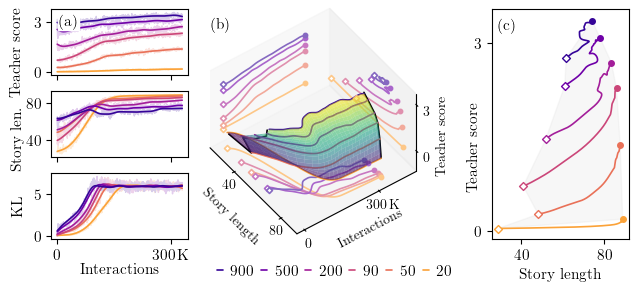

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
import matplotlib.colors as mcolors

#--- Helper as above (Define blend_with_white, fields, score_list, revision_numbers, ppo_colors, batch_stats_dict etc.) ---

fraction = 1.0 / 0.84
figsize = set_size(ncols=2, fraction=fraction, aspect_ratio=0.4)
fig = plt.figure(figsize=figsize)

# 3 columns: left (stacked), center (3D), right (score-v-length)
gs = GridSpec(3, 3, width_ratios=[0.5, 0.9, 0.5], height_ratios=[1, 1, 1], wspace=0.16, hspace=0.25, figure=fig)

# Panel A: stacked 3 left plots (fields)
left_axes = [fig.add_subplot(gs[i, 0]) for i in range(3)]  # vertical stack

# Panel B: 3D plot (center, spans all 3 rows)
center_ax = fig.add_subplot(gs[:, 1], projection='3d', proj_type='ortho')

# Panel C: score-vs-length plot (right, middle row)
right_ax = fig.add_subplot(gs[:, 2])

#--- LEFT: stacked fields plot (your second code block, adapted) ---
fields = [
    ('avg_score_sum', r'Teacher score'),
    ('student_len', r'Story len.'),
    ('kl', 'KL'),
]
skip = 3
sigma = 30  # Smoothing std
markersize_3D = 3
markersize = 4
lw = 1.2

for idx, (fieldname, fieldlabel) in enumerate(fields):
    ax = left_axes[idx]
    for color, revision in zip(ppo_colors, revision_numbers):
        df = batch_stats_dict[revision]
        interaction_rounds = df['interaction_round'].values / 1e5
        y = df[fieldname].values
        y_smooth = gaussian_filter1d(y, sigma=sigma, mode='nearest')

        pale = blend_with_white(mcolors.to_rgb(color), amount=0.8)
        ax.plot(interaction_rounds, y, color=pale, linewidth=1)
        ax.plot(interaction_rounds, y_smooth, color=color, linewidth=lw, label=rf"{revision}\,M", zorder=3)

    ax.set_xticks([0,3])
    if idx == 1:
        ax.set_yticks([40,80])
    ax.set_ylabel(fieldlabel, labelpad=6)
    if idx == 0:
        ax.yaxis.set_label_coords(-0.20, 0.34)
    if idx == 0:
        ax.set_yticks([0,3])
    if idx < 2:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel(r'Interactions', labelpad=1)
        ax.set_xticklabels([0,r'300\,K'])
    if idx == 1:
        ax.yaxis.set_label_coords(-0.20, 0.28)


#ax.text(
#    0.99, -0.25, r"$\times 10^5$",  # (x, y) = near the right end, below axis
#    ha="right", va="center",
#    transform=ax.transAxes,
#    fontsize=11
#)

#--- CENTER: your 3D plot (central panel, keep code) ---
all_rounds = np.concatenate([df['interaction_round'].values / 1e5 for df in batch_stats_dict.values()])
round_grid = np.linspace(all_rounds.min(), all_rounds.max(), 130)
student_grid, score_grid = [], []
for revision in revision_numbers:
    df = batch_stats_dict[revision]
    rounds = df['interaction_round'].values / 1e5
    student = gaussian_filter1d(df['student_len'].values, sigma=sigma, mode='nearest')
    score = gaussian_filter1d(df['avg_score_sum'].values, sigma=sigma, mode='nearest')
    st_interp = interp1d(rounds, student, bounds_error=False, fill_value=np.nan)
    sc_interp = interp1d(rounds, score, bounds_error=False, fill_value=np.nan)
    student_grid.append(st_interp(round_grid))
    score_grid.append(sc_interp(round_grid))
student_grid = np.array(student_grid)
score_grid = np.array(score_grid)
ROUNDS = np.tile(round_grid, (len(revision_numbers), 1))
n_models, n_prompts = student_grid.shape

dense_model_axis = np.linspace(0, n_models-1, 40)
dense_student, dense_score = [], []
for pi in range(n_prompts):
    student_across_models = student_grid[:, pi]
    score_across_models = score_grid[:, pi]
    f_student = interp1d(np.arange(n_models), student_across_models, kind="linear")
    f_score = interp1d(np.arange(n_models), score_across_models, kind="linear")
    dense_student.append(f_student(dense_model_axis))
    dense_score.append(f_score(dense_model_axis))
dense_student = np.array(dense_student).T
dense_score = np.array(dense_score).T
dense_round = np.tile(round_grid, (len(dense_model_axis), 1))

surf = center_ax.plot_surface(
    dense_student,       # x
    dense_round,        # y
    dense_score,         # z
    cmap='viridis',
    alpha=0.6,
    linewidth=0.5,
    ccount=30,
    rcount=30,
    edgecolor='None',
    antialiased=True,
    zorder=-1,
)
proj_score  = -1
proj_rounds  = 4.2
proj_length = 24
alpha_proj = 1.0
alpha_orig = 1.0
for student_curve, score_curve, color, rev_lab in zip(student_grid, score_grid, ppo_colors, revision_numbers):
    pale = blend_with_white(mcolors.to_rgb(color), amount=0.4)
    center_ax.plot(student_curve, round_grid, score_curve, color=color, lw=lw, label=rf"{rev_lab}", linestyle='-')
    # projections and extra markers as in your code
    center_ax.scatter(proj_length + 0 * student_curve[0], round_grid[0], score_curve[0], marker='D', color=pale, s=markersize_3D**2, facecolor='white', alpha=alpha_proj, zorder=-3, linewidth=lw)
    center_ax.scatter(proj_length + 0 * student_curve[-1], round_grid[-1], score_curve[-1], marker='o', color=pale, s=markersize_3D**2, facecolor=pale, alpha=alpha_proj, zorder=-3, linewidth=lw)
    center_ax.scatter(student_curve[0], proj_rounds + 0 * round_grid[0], score_curve[0], marker='D', color=pale, s=markersize_3D**2, facecolor='white', alpha=alpha_proj, zorder=-3, linewidth=lw)
    center_ax.scatter(student_curve[-1], proj_rounds + 0 * round_grid[-1], score_curve[-1], marker='o', color=pale, s=markersize_3D**2, facecolor=pale, alpha=alpha_proj, zorder=-3, linewidth=lw)
    center_ax.scatter(student_curve[0], round_grid[0], proj_score + 0 * score_curve[0], marker='D', color=pale, s=markersize_3D**2, facecolor='white', alpha=alpha_proj, zorder=-3, linewidth=lw)
    center_ax.scatter(student_curve[-1], round_grid[-1], proj_score + 0 * score_curve[-1], marker='o', color=pale, s=markersize_3D**2, facecolor=pale, alpha=alpha_proj, zorder=-3, linewidth=lw)
    center_ax.plot(proj_length + 0 * student_curve, round_grid,  score_curve, color=pale, linestyle='-', alpha=alpha_proj, zorder=-3, linewidth=lw)
    center_ax.plot(student_curve, proj_rounds + 0 * round_grid,  score_curve, color=pale, linestyle='-', alpha=alpha_proj, zorder=-3, linewidth=lw)
    center_ax.plot(student_curve, round_grid, proj_score + 0 * score_curve, color=pale, linestyle='-', alpha=alpha_proj, zorder=-3, linewidth=lw)

center_ax.set_xlabel("Story length", labelpad=-5, fontsize=fontsize - 1)
center_ax.set_ylabel(r"Interactions", labelpad=-7, fontsize=fontsize - 1)
center_ax.set_zlabel("Teacher score", labelpad=-10, fontsize=fontsize - 1)
#scalefactor_label = r'$\times 10^5$'
#center_ax.text(
#    20, 50, -30, scalefactor_label,
#    zdir='y',
#    transform=center_ax.transAxes,
#    va="center", ha="right", fontsize=fontsize - 1
#)
center_ax.set_xticks([40,80])
center_ax.set_yticks([0,3])
center_ax.set_yticklabels([0,r'300\,K'])
center_ax.set_zticks([0,3])
for tick_label in (center_ax.get_xticklabels() +
                   center_ax.get_yticklabels() +
                   center_ax.get_zticklabels()):
    tick_label.set_fontsize(fontsize - 1)
tick_pad = -4
center_ax.xaxis.set_tick_params(pad=tick_pad)
center_ax.yaxis.set_tick_params(pad=tick_pad)
center_ax.zaxis.set_tick_params(pad=tick_pad)
handles, labels = center_ax.get_legend_handles_labels()
#center_ax.legend(handles[::-1], labels[::-1], frameon=False, handlelength=0.5, handletextpad=0.5, loc='upper left', bbox_to_anchor=(0.75,1.0), ncols=2)
center_ax.grid(False)
center_ax.view_init(elev=46, azim=-36, roll=0)

# Shift center axis to left
pos = center_ax.get_position()
new_pos = [pos.x0 - 0.04, pos.y0, pos.width, pos.height]  # shift left by 0.04 (fraction of fig)
center_ax.set_position(new_pos)

#--- RIGHT: score vs length panel (your last code block, on right column, middle row only) ---
# [You may also want: right_ax = fig.add_subplot(gs[1, 2])]
student_len_smooth_start = []
student_len_smooth_end = []
score_smooth_start = []
score_smooth_end = []

for color, revision in zip(ppo_colors, revision_numbers):
    df = batch_stats_dict[revision]
    story_len = df['student_len'].to_numpy()
    score = df['avg_score_sum'].to_numpy()

    score_smooth = gaussian_filter1d(score, sigma=sigma, mode='mirror')
    student_len_smooth = gaussian_filter1d(story_len, sigma=sigma, mode='mirror')

    student_len_smooth_start.append(student_len_smooth[0])
    student_len_smooth_end.append(student_len_smooth[-1])
    score_smooth_start.append(score_smooth[0])
    score_smooth_end.append(score_smooth[-1])

    right_ax.plot(student_len_smooth, score_smooth, linewidth=lw, color=color, label=rf"{revision}")
    right_ax.scatter(student_len_smooth[0], score_smooth[0], marker='D', color=color, facecolor='white', s=markersize**2, zorder=5)
    right_ax.scatter(student_len_smooth[-1], score_smooth[-1], marker='o', color=color, facecolor=color, s=markersize**2, zorder=5)

right_ax.fill(
    np.concatenate([student_len_smooth_start, student_len_smooth_end[::-1]]),
    np.concatenate([score_smooth_start, score_smooth_end[::-1]]),
    color=[0.8,0.8,0.8],
    alpha=0.15,
    zorder=0,
    linestyle='-'
)
#right_ax.plot(student_len_smooth_start, score_smooth_start, linewidth=lw, color="black", zorder=0)
#right_ax.plot(student_len_smooth_end, score_smooth_end, linewidth=lw, color="black", zorder=0)
right_ax.set_xticks([40,80])
right_ax.set_yticks([0,3])
right_ax.set_xlabel('Story length')
right_ax.set_ylabel('Teacher score', labelpad=0)
right_ax.yaxis.set_label_coords(-0.08, 0.4)
handles, labels = right_ax.get_legend_handles_labels()
right_ax.legend(handles[::-1], labels[::-1], frameon=False, ncols=6, columnspacing=0.5, handlelength=0.4, handletextpad=0.5, loc='upper left', bbox_to_anchor=(-2.1, -0.05))


center_ax.plot(student_len_smooth_start, np.min(round_grid) * np.ones(len(score_smooth_start)) , score_smooth_start, linewidth=lw, color="black", zorder=-2)
center_ax.plot(student_len_smooth_end, np.max(round_grid) * np.ones(len(score_smooth_end)) , score_smooth_end, linewidth=lw, color="black", zorder=-2)


panel_labels = ['(a)', '(b)', '(c)']
for i, ax in enumerate(left_axes):
    if i == 0:
        ax.text(
            0.06, 0.92, panel_labels[i], fontsize=fontsize, fontweight="bold",
            ha="left", va="top", transform=ax.transAxes,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1')
        )

# (b): to the left of the top left main plot
center_ax.text(
    90, 4, 80, "(b)", fontsize=fontsize, fontweight="bold",
    ha="left", va="top", transform=center_ax.transAxes, color='black'
)

right_ax.text(
    0.05, 0.96, '(c)', fontsize=fontsize, fontweight='bold',
    ha='left', va='top', transform=right_ax.transAxes,
    color='black'
)

#plt.tight_layout()
#plt.savefig("figs/PPO_dynamics.pdf", bbox_inches='tight', pad_inches=0.03)
#check_pdf_size("figs/PPO_dynamics.pdf", figsize, fraction)
plt.show()

In [15]:
score_smooth_end

[np.float64(0.18644728027410995),
 np.float64(1.3715940626223502),
 np.float64(2.2776652303392666),
 np.float64(2.6908890618088916),
 np.float64(3.091025032093208),
 np.float64(3.3643433866577754)]

In [16]:
score_smooth_start

[np.float64(0.03583388838995941),
 np.float64(0.26492491412584623),
 np.float64(0.7144909112118273),
 np.float64(1.464195282418415),
 np.float64(2.3212075287589045),
 np.float64(2.765106337950397)]

#### Stereogram

=== PDF actual area ===:
  706.31pt x 327.42pt  ||  9.8098in x 4.5475in
=== Your target figsize from set_size, corrected for fraction:
  536.91pt x 214.76pt  ||  7.4571in x 2.9828in
=== Ratio (actual/target):
  width: 131.55%,  height: 152.45%


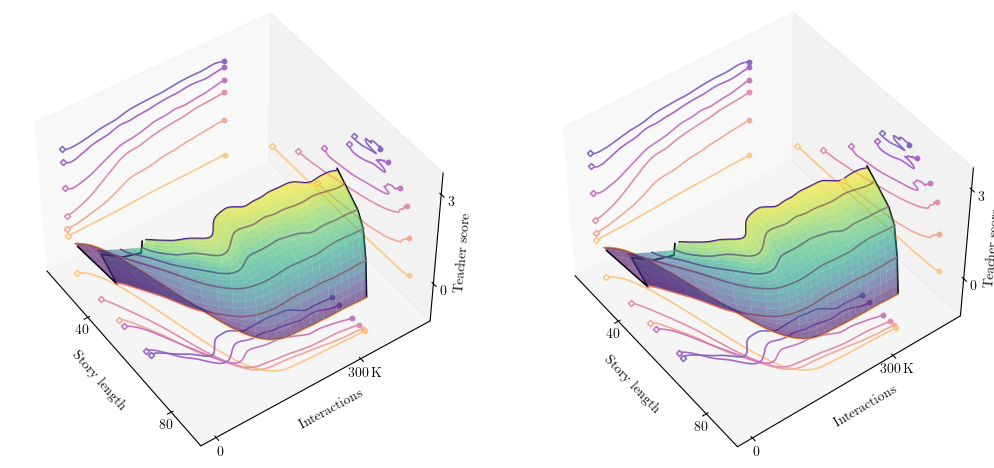

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import numpy as np

# === Helper: Set your stereo viewpoint deltas ===
stereo_delta_deg = 2   # difference in azimuth between left/right
azim_center = -36       # Azimuth
elev_angle = 46         # Elevation

# === Build stereo figure and axes ===
fraction = 1.0 / 1
fig_width = 2 * set_size(ncols=2, fraction=fraction, aspect_ratio=1)[0]
fig_height = set_size(ncols=2, fraction=fraction, aspect_ratio=1)[1]
fig, axes = plt.subplots(
    1, 2, subplot_kw={"projection": "3d"},
    figsize=(fig_width, fig_height)
)

for i, ax in enumerate(axes):
    # Set perspective for stereo effect
    azim = azim_center + (stereo_delta_deg / 2 if i == 0 else -stereo_delta_deg / 2)
    ax.view_init(elev=elev_angle, azim=azim, roll=0)

    # --- Copy code for drawing your 3D data as in the middle panel above ---
    surf = ax.plot_surface(
        dense_student,       # x
        dense_round,         # y
        dense_score,         # z
        cmap='viridis',
        alpha=0.6,
        linewidth=0.5,
        ccount=30,
        rcount=30,
        edgecolor='None',
        antialiased=True,
        zorder=-1,
    )

    # Plot 3D trajectories, projections, etc.
    for student_curve, score_curve, color, rev_lab in zip(student_grid, score_grid, ppo_colors, revision_numbers):
        pale = blend_with_white(mcolors.to_rgb(color), amount=0.4)
        ax.plot(student_curve, round_grid, score_curve, color=color, lw=lw, label=rf"{rev_lab}", linestyle='-')
        # Projections and extra markers as in your original code
        ax.scatter(proj_length + 0 * student_curve[0], round_grid[0], score_curve[0], marker='D', color=pale, s=markersize_3D**2, facecolor='white', alpha=alpha_proj, zorder=-3, linewidth=lw)
        ax.scatter(proj_length + 0 * student_curve[-1], round_grid[-1], score_curve[-1], marker='o', color=pale, s=markersize_3D**2, facecolor=pale, alpha=alpha_proj, zorder=-3, linewidth=lw)
        ax.scatter(student_curve[0], proj_rounds + 0 * round_grid[0], score_curve[0], marker='D', color=pale, s=markersize_3D**2, facecolor='white', alpha=alpha_proj, zorder=-3, linewidth=lw)
        ax.scatter(student_curve[-1], proj_rounds + 0 * round_grid[-1], score_curve[-1], marker='o', color=pale, s=markersize_3D**2, facecolor=pale, alpha=alpha_proj, zorder=-3, linewidth=lw)
        ax.scatter(student_curve[0], round_grid[0], proj_score + 0 * score_curve[0], marker='D', color=pale, s=markersize_3D**2, facecolor='white', alpha=alpha_proj, zorder=-3, linewidth=lw)
        ax.scatter(student_curve[-1], round_grid[-1], proj_score + 0 * score_curve[-1], marker='o', color=pale, s=markersize_3D**2, facecolor=pale, alpha=alpha_proj, zorder=-3, linewidth=lw)
        ax.plot(proj_length + 0 * student_curve, round_grid,  score_curve, color=pale, linestyle='-', alpha=alpha_proj, zorder=-3, linewidth=lw)
        ax.plot(student_curve, proj_rounds + 0 * round_grid,  score_curve, color=pale, linestyle='-', alpha=alpha_proj, zorder=-3, linewidth=lw)
        ax.plot(student_curve, round_grid, proj_score + 0 * score_curve, color=pale, linestyle='-', alpha=alpha_proj, zorder=-3, linewidth=lw)
    # Add projections at the base/edge
    ax.plot(student_len_smooth_start, np.min(round_grid) * np.ones(len(score_smooth_start)), score_smooth_start, linewidth=lw, color="black", zorder=-2)
    ax.plot(student_len_smooth_end, np.max(round_grid) * np.ones(len(score_smooth_end)), score_smooth_end, linewidth=lw, color="black", zorder=-2)

    # Style
    ax.set_xlabel("Story length", labelpad=-5, fontsize=fontsize - 1)
    ax.set_ylabel(r"Interactions", labelpad=-7, fontsize=fontsize - 1)
    ax.set_zlabel("Teacher score", labelpad=-10, fontsize=fontsize - 1)
    ax.set_xticks([40, 80])
    ax.set_yticks([0, 3])
    ax.set_yticklabels([0, r'300\,K'])
    ax.set_zticks([0, 3])
    for tick_label in (ax.get_xticklabels() + ax.get_yticklabels() + ax.get_zticklabels()):
        tick_label.set_fontsize(fontsize - 1)
    tick_pad = -4
    ax.xaxis.set_tick_params(pad=tick_pad)
    ax.yaxis.set_tick_params(pad=tick_pad)
    ax.zaxis.set_tick_params(pad=tick_pad)
    ax.grid(False)

#plt.tight_layout()
plt.savefig("figs/PPO_dynamics_stereo.pdf", bbox_inches='tight', pad_inches=0.03)
check_pdf_size("figs/PPO_dynamics_stereo.pdf", figsize, fraction)
plt.show()

## Visualization

## Final evals

In [30]:
from pathlib import Path
import pandas as pd

# === Metric rename mapping ===
METRIC_RENAME = {
    "BLIMP": "BLiMP",
    "SUPPLEMENT": "Suppl.",
    "ENTITY": "ET",
    "EWOK": "EWOK",
    "WUG_ADJ": "WUG Adj",
    "WUG_PAST": "WUG Past",
    "COMPS": "COMPS",
    "READING (SPR)": "SPR",
    "READING (ET)": "Eye-T",
    "GLUE": "GLUE",
    "AOA": "AoA"
}

BASE_DIR = Path("eval/results")

# === Models to plot ===
MODELS = {
    "1000M-pre": {
        "path": "babylm-baseline-100m-gpt2/eval_main.csv",
        "color": "black",
        "zorder": 3
    },
    "SimPO": {
        "path": "babylm-interaction-baseline-simpo/eval_main.csv",
        "color": "tab:gray",
        "zorder": 3
    },
    "900M-pre": {
        "path": "blm-gpt2s-90M-s42_901M-s42_submission/eval_chck_900M.csv",
        "color": "tab:blue",
        "zorder": 2
    },
    "900M-RL": {
        "path": "blm-gpt2s-90M-s42_901M-s42_submission/eval_main.csv",
        "color": "tab:red",
        "zorder": 4
    }
}

def load_eval_csvs(models: dict, base_dir: Path) -> pd.DataFrame:
    rows = []
    for model_name, style in models.items():
        csv_path = base_dir / style["path"]
        if not csv_path.exists():
            raise FileNotFoundError(f"Missing eval CSV: {csv_path}")
        df = pd.read_csv(csv_path)
        for _, row in df.iterrows():
            metric_disp = METRIC_RENAME.get(row["Metric"], row["Metric"])
            rows.append({
                "Metric": metric_disp,
                "Score": row["Score"],
                "Model": model_name,
                "Color": style["color"],
                "Zorder": style["zorder"]
            })
    return pd.DataFrame(rows)

df_eval = load_eval_csvs(MODELS, BASE_DIR)
df_eval.head()

,Metric,Score,Model,Color,Zorder
0,BLiMP,74.880924,1000M-pre,black,3
1,Suppl.,63.315881,1000M-pre,black,3
2,EWOK,51.671384,1000M-pre,black,3
3,ET,31.509803,1000M-pre,black,3
4,WUG Adj,50.238826,1000M-pre,black,3


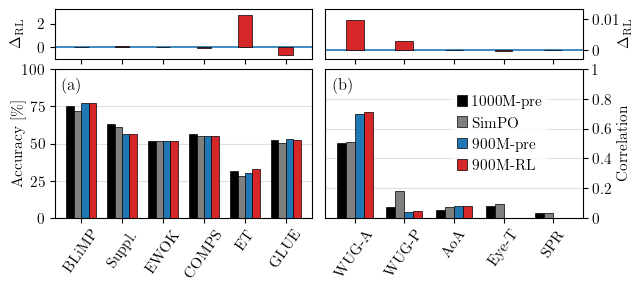

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd

# Metric rename mapping
METRIC_RENAME = {
    "BLIMP": "BLiMP",
    "SUPPLEMENT": "Suppl.",
    "ENTITY": "ET",
    "EWOK": "EWOK",
    "WUG_ADJ": "WUG-A",
    "WUG_PAST": "WUG-P",
    "COMPS": "COMPS",
    "READING (SPR)": "SPR",
    "READING (ET)": "Eye-T",
    "GLUE": "GLUE",
    "AOA": "AoA"
}

BASE_DIR = Path("eval/results")

MODELS = {
    "1000M-pre": {
        "path": "babylm-baseline-100m-gpt2/eval_main.csv",
        "color": "black", "zorder": 3
    },
    "SimPO": {
        "path": "babylm-interaction-baseline-simpo/eval_main.csv",
        "color": "tab:gray", "zorder": 3
    },
    "900M-pre": {
        "path": "blm-gpt2s-90M-s42_901M-s42_submission/eval_chck_900M.csv",
        "color": "tab:blue", "zorder": 2
    },
    "900M-RL": {
        "path": "blm-gpt2s-90M-s42_901M-s42_submission/eval_main.csv",
        "color": "tab:red", "zorder": 4
    }
}

baseline_color = MODELS['900M-pre']["color"]

def load_eval_csvs(models, base_dir):
    rows = []
    for model_name, style in models.items():
        csv_path = base_dir / style["path"]
        if not csv_path.exists():
            raise FileNotFoundError(f"Missing eval CSV: {csv_path}")
        df = pd.read_csv(csv_path)
        for _, row in df.iterrows():
            metric_disp = METRIC_RENAME.get(row["Metric"], row["Metric"])
            rows.append({
                "Metric": metric_disp,
                "Score": row["Score"],
                "Model": model_name,
                "Color": style["color"],
                "Zorder": style["zorder"]
            })
    return pd.DataFrame(rows)

df_eval = load_eval_csvs(MODELS, BASE_DIR)

# Metric sets
ACC_METRICS = ["BLiMP", "Suppl.", "EWOK", "COMPS", "ET", "GLUE"]
NONACC_METRICS = ["WUG-A", "WUG-P", "AoA", "Eye-T", "SPR"]

acc_order = ACC_METRICS
nonacc_order = NONACC_METRICS
model_names_in_order = list(MODELS.keys())
n_models = len(model_names_in_order)
width_bottom = 0.18        # keep existing for bottom row
width_top = width_bottom * 2   # ~30% slimmer for top row
edgewidth = 0.5
edgecolor = 'black'

# --- Compute differences (900M-RL − 900M-pre) ---
diffs_acc = []
for metric in acc_order:
    rl = df_eval.loc[(df_eval["Metric"] == metric) & (df_eval["Model"] == "900M-RL"), "Score"].values[0]
    pre = df_eval.loc[(df_eval["Metric"] == metric) & (df_eval["Model"] == "900M-pre"), "Score"].values[0]
    diffs_acc.append(rl - pre)

diffs_nonacc = []
for metric in nonacc_order:
    rl = df_eval.loc[(df_eval["Metric"] == metric) & (df_eval["Model"] == "900M-RL"), "Score"].values[0]
    pre = df_eval.loc[(df_eval["Metric"] == metric) & (df_eval["Model"] == "900M-pre"), "Score"].values[0]
    # Convert correlation type from ×100 back to 0–1
    if metric in ["WUG-A", "WUG-P", "Eye-T", "SPR"]:
        rl /= 100.0
        pre /= 100.0
    diffs_nonacc.append(rl - pre)

# --- Figure with 2×2 layout, top row smaller ---
fraction = 1.0 / 0.9569
figsize = set_size(ncols=2, fraction=fraction, aspect_ratio=0.5)  # a bit taller for 2 rows
fig, axes = plt.subplots(
    2, 2, figsize=figsize, sharex='col',
    gridspec_kw={"height_ratios": [1, 3]}
)

ax_diff_left, ax_diff_right = axes[0]
ax_left, ax_right = axes[1]

# --- TOP LEFT: Accuracy differences ---
ax_diff_left.bar(np.arange(len(acc_order)), diffs_acc, color="tab:red", edgecolor=edgecolor, linewidth=edgewidth, width=width_top)
ax_diff_left.axhline(0, color=baseline_color, lw=1.2, zorder=0)
ax_diff_left.set_ylabel(r"$\Delta_{\mathrm{RL}}$", labelpad=10)
#ax_diff_left.grid(axis='y', linestyle='-', alpha=0.4)
ax_diff_left.set_xticks([])
ax_diff_left.set_xticklabels([])
ax_diff_left.set_ylim([-1,3.2]),
ax_diff_left.set_yticks([0,2])
ax_diff_left.set_yticklabels([0,2])

# --- TOP RIGHT: Non-Accuracy differences ---
ax_diff_right.bar(np.arange(len(nonacc_order)), diffs_nonacc, color="tab:red", edgecolor=edgecolor, linewidth=edgewidth, width=width_top)
ax_diff_right.axhline(0, color=baseline_color, lw=1.2, zorder=0)
ax_diff_right.set_ylabel(r"$\Delta_{\mathrm{RL}}$", labelpad=-1)
##ax_diff_right.grid(axis='y', linestyle='-', alpha=0.4)
ax_diff_right.set_xticks([])
ax_diff_right.set_xticklabels([])
ax_diff_right.set_ylim([-0.003,0.013]),
ax_diff_right.set_yticks([0,0.01])
ax_diff_right.set_yticklabels([0,0.01])

# --- BOTTOM LEFT: Accuracy results ---
for i, model in enumerate(model_names_in_order):
    col = MODELS[model]["color"]; z = MODELS[model]["zorder"]
    yvals = [
        df_eval.loc[(df_eval["Metric"] == metric) & (df_eval["Model"] == model), "Score"].values[0]
        for metric in acc_order
    ]
    xpos = np.arange(len(acc_order)) + i * width_bottom - (width_bottom * n_models / 2) + width_bottom / 2
    ax_left.bar(xpos, yvals, width=width_bottom, color=col, edgecolor=edgecolor, linewidth=edgewidth, zorder=z, label=model)

ax_left.set_ylabel(r"Accuracy [\%]", labelpad=-3)
ax_left.set_ylim(0, 100)
ax_left.grid(axis='y', linestyle='-', alpha=0.4)
ax_left.set_xticks(np.arange(len(acc_order)))
ax_left.set_xticklabels(acc_order, rotation=55, ha="center")

# --- BOTTOM RIGHT: Non-Accuracy results ---
for i, model in enumerate(model_names_in_order):
    col = MODELS[model]["color"]; z = MODELS[model]["zorder"]
    yvals = []
    for metric in nonacc_order:
        val = df_eval.loc[(df_eval["Metric"] == metric) & (df_eval["Model"] == model), "Score"].values[0]
        if metric in ["WUG-A", "WUG-P", "Eye-T", "SPR"]:
            val /= 100.0
        yvals.append(val)
    xpos = np.arange(len(nonacc_order)) + i * width_bottom - (width_bottom * n_models / 2) + width_bottom / 2
    ax_right.bar(xpos, yvals, width=width_bottom, color=col, edgecolor=edgecolor, linewidth=edgewidth, zorder=z)

ax_right.set_ylabel(r"Correlation")
ax_right.set_ylim(0, 1)
ax_right.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax_right.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax_right.grid(axis='y', linestyle='-', alpha=0.4)
ax_right.set_xticks(np.arange(len(nonacc_order)))
ax_right.set_xticklabels(nonacc_order, rotation=55, ha="center")


ax_diff_right.yaxis.set_label_position("right")
ax_diff_right.yaxis.tick_right()

ax_right.yaxis.set_label_position("right")
ax_right.yaxis.tick_right()

# --- Legend ---
legend_handles = [
    plt.Rectangle((0,0), 1, 1, facecolor=style["color"], edgecolor='black', lw=edgewidth, label=name)
    for name, style in MODELS.items()
]
fig.legend(
    handles=legend_handles,
    labels=MODELS.keys(),  # model names in order
    loc='center right', ncol=1, bbox_to_anchor=(0.86, 0.5),
    columnspacing=1, frameon=True, edgecolor='None',
    borderpad=0.4, handlelength=0.7, handletextpad=0.3
)

# Add subplot panel labels
ax_left.text(0.03, 0.95, "(a)", transform=ax_left.transAxes,
             ha='left', va='top', fontsize=12, fontweight='bold')
ax_right.text(0.03, 0.95, "(b)", transform=ax_right.transAxes,
              ha='left', va='top', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(top=0.88, hspace=0.1, wspace=0.05)
#plt.savefig("figs/blm_eval.pdf", bbox_inches='tight', pad_inches=0.03)
#check_pdf_size("figs/blm_eval.pdf", figsize, fraction)
plt.show()